In [432]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as patches


In [438]:
nfl = pd.read_csv("/Users/anuragreddy/Desktop/Sports Analytics/nfl.csv", low_memory=False)

In [456]:
nfl.dropna(
    subset=['yardline_100', 'game_seconds_remaining', 'down', 'ydstogo',
            'posspread', 'score_differential', 'poswins', 'ydsnet',
            'qb_dropback'],
    how='any',
    inplace=True
)


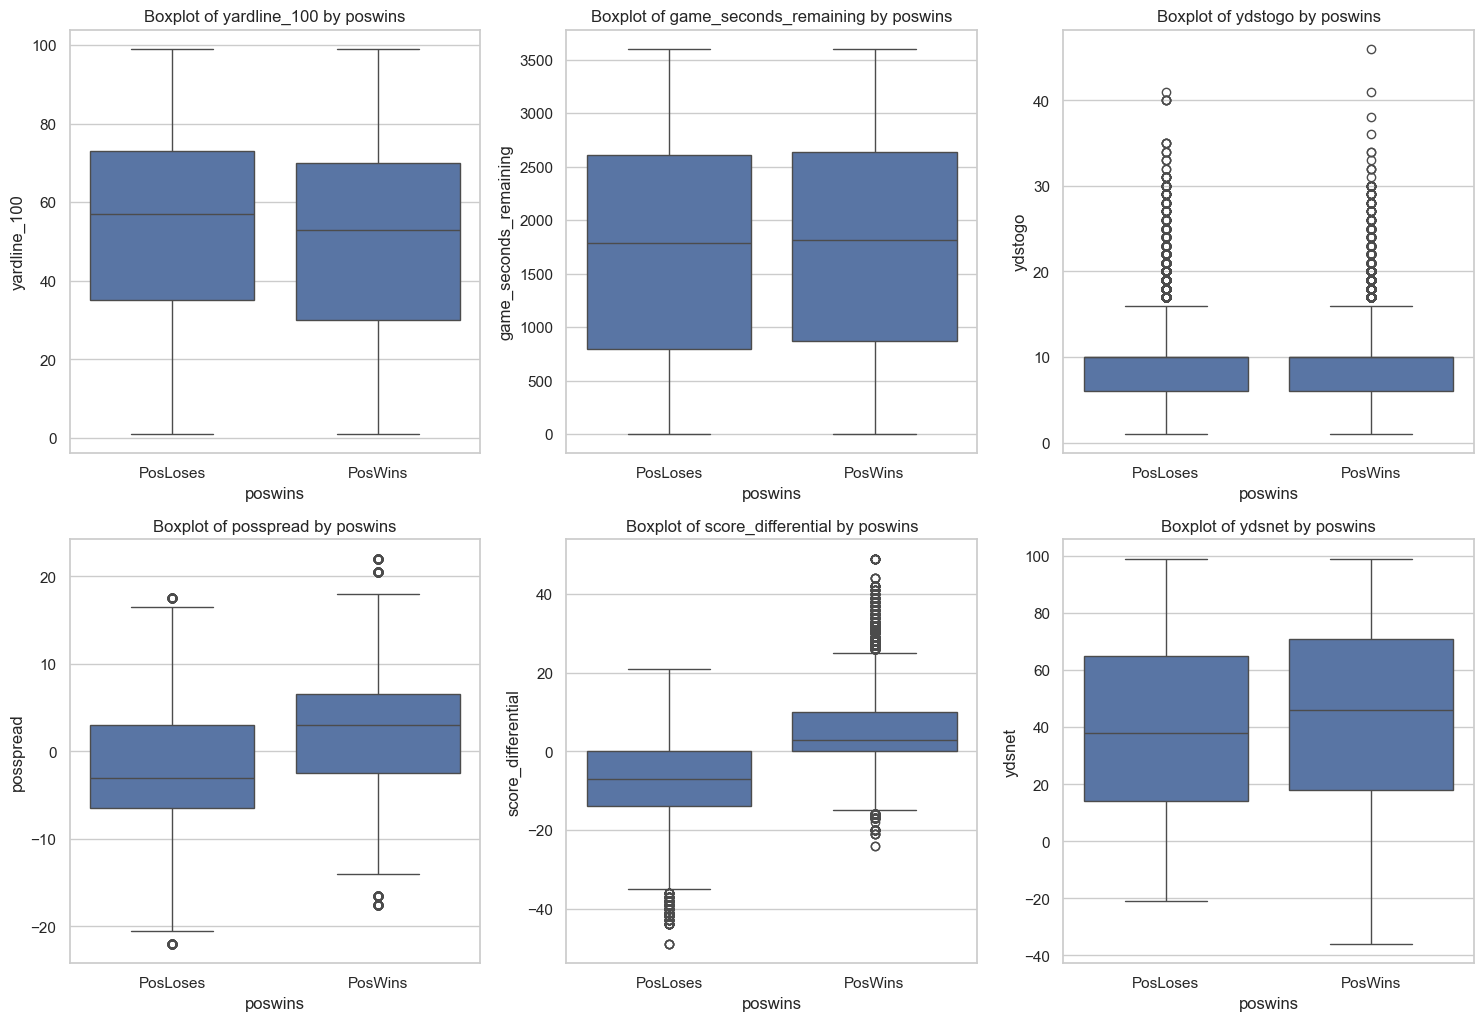

In [457]:
data = nfl[['yardline_100','game_seconds_remaining','down','ydstogo','posspread','score_differential','poswins','ydsnet','qb_dropback']]
data.loc[:, 'down'] = data['down'].astype('category')
data.loc[:, 'qb_dropback'] = data['qb_dropback'].astype('category')


numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='poswins', y=feature, data=data)
    plt.title(f'Boxplot of {feature} by poswins')
plt.tight_layout()
plt.show()

**Insights**
- The variables Yardline_100, Yardstogo, Score differential, possspread, and ydsnet (yards gained on drive) are more effective in differentiating winners and losers.

In [458]:
data = data.dropna()

**Logstic Regression** (Using same model as used in class but with different variables)

In [475]:
design = MS(data.columns.drop('poswins'))
X = design.fit_transform(data)
y = data['poswins'].map({'PosWins':1,'PosLoses':0})

In [489]:
X_train,X_test,y_train,y_test = skm.train_test_split(X,y,test_size=0.2,random_state=0)
model = sm.GLM(y_train,X_train,family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                poswins   No. Observations:                62656
Model:                            GLM   Df Residuals:                    62645
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27161.
Date:                Sun, 17 Nov 2024   Deviance:                       54321.
Time:                        08:46:44   Pearson chi2:                 5.56e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4050
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0

Adding **ydsnet** and **qb_dropback** to your logistic regression model for predicting game winners introduces valuable information that can enhance the model's predictive power. Here's an in-depth explanation of the importance of these newly added variables:

### 1. **ydsnet (Total Yards Gained on the Drive)**

**Definition:**  
`ydsnet` represents the numeric value of total yards gained by a team during a particular drive. This metric accumulates the net yards achieved from the start to the end of a drive, encompassing both successful and unsuccessful plays.

**Importance and Impact:**

- **Offensive Effectiveness:**  
  `ydsnet` serves as a direct indicator of a team's offensive performance. Higher yards gained typically correlate with better offensive efficiency, increasing the likelihood of scoring points and, consequently, winning the game.


### 2. **qb_dropback (Quarterback Dropback Indicator)**

**Definition:**  
`qb_dropback` is a binary variable indicating whether the quarterback (QB) has dropped back on a play. A dropback occurs during pass attempts, sacks, or scrambles. Essentially, it signifies that the QB is engaged in initiating a pass play or evading pressure from the defense.

**Importance and Impact:**

- **Play Type Identification:**  
  This variable helps differentiate between run plays and pass plays. Pass-heavy strategies can influence the game's dynamics differently compared to run-focused approaches.

- **Pass Attempt Indicator:**  
  A dropback typically precedes a pass attempt, which can lead to significant yardage gains or turnovers (e.g., interceptions). Understanding the frequency and context of pass attempts aids in assessing offensive aggressiveness and risk-taking behavior.

- **Sack and Pressure Handling:**  
  Instances where the QB is sacked or scrambles (without a pass) indicate the defense's pressure level. High pressure can disrupt offensive rhythm, leading to negative yardage or turnovers, impacting the game's outcome.



### **Interpreting the Coefficient qb_dropback**

#### 1. **Direction and Magnitude**

- **Coefficient Value:** `-0.1544`
  
  - **Negative Sign (-):** Indicates an inverse relationship between the predictor and the outcome variable.
  - **Magnitude (0.1544):** Represents the strength of the relationship.

- **Interpretation:**  
  For each unit increase in `qb_dropback` (i.e., when `qb_dropback` changes from `0` to `1`), the log-odds of the home team winning **decrease** by `0.1544`, holding all other variables constant.


### **Summary**

- **Practical Implications:**  
  Incorporating `qb_dropback` into the model provides valuable insights into how certain offensive strategies impact the likelihood of winning, enabling more informed decision-making and strategic planning.


In [490]:
pred = model.predict(X_test)
labels = np.array(['PosLoses']*len(X_test))
labels[pred>0.5] = 'PosWins'
confusion_matrix = confusion_table(labels,y_test.map({1:'PosWins',0:'PosLoses'}))
confusion_matrix

Truth,PosLoses,PosWins
Predicted,,
PosLoses,6048,1500
PosWins,1676,6440


In [496]:
acc = accuracy_score(labels,y_test.map({1:'PosWins',0:'PosLoses'}))*100
print("The accuracy of the above model is:", str(round(acc,2)) + "%")
print("This model performed only slightly betetr compared to the base model developed in the class (79% accuracy)")

The accuracy of the above model is: 79.72%
This model performed only slightly betetr compared to the base model developed in the class (79% accuracy)


In [492]:
prob_log = model.predict(X)
nfl['prob_log'] = prob_log
nfl['prob_home_log'] = np.where(nfl['posteam'] == nfl['home_team'],nfl['prob_log'],1 - nfl['prob_log'])

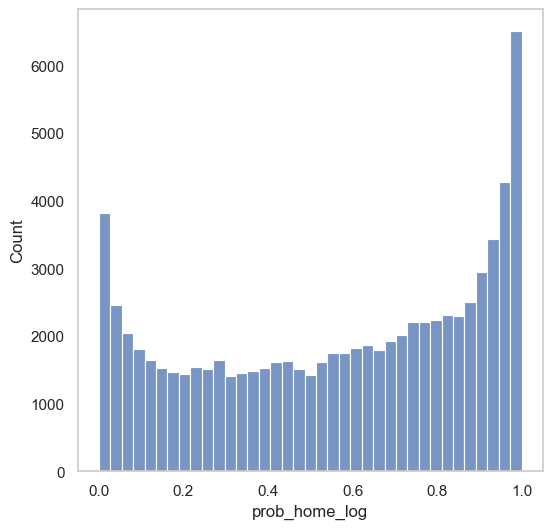

In [493]:
plt.figure(figsize=(6,6))
sns.histplot(x='prob_home_log',data=nfl)
plt.grid(False)
plt.show()

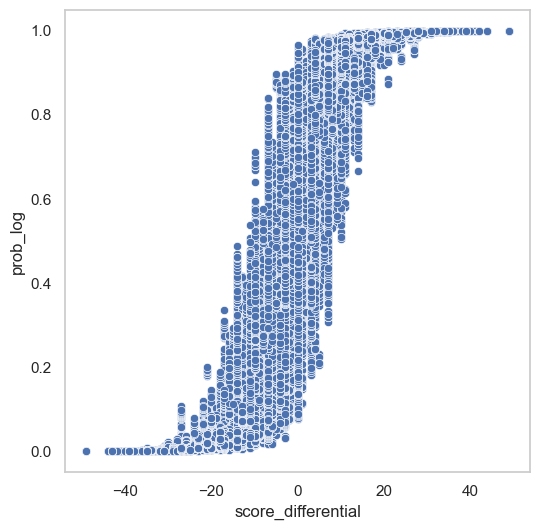

In [494]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='score_differential',y='prob_log',data=nfl)
plt.grid(False)
plt.show()

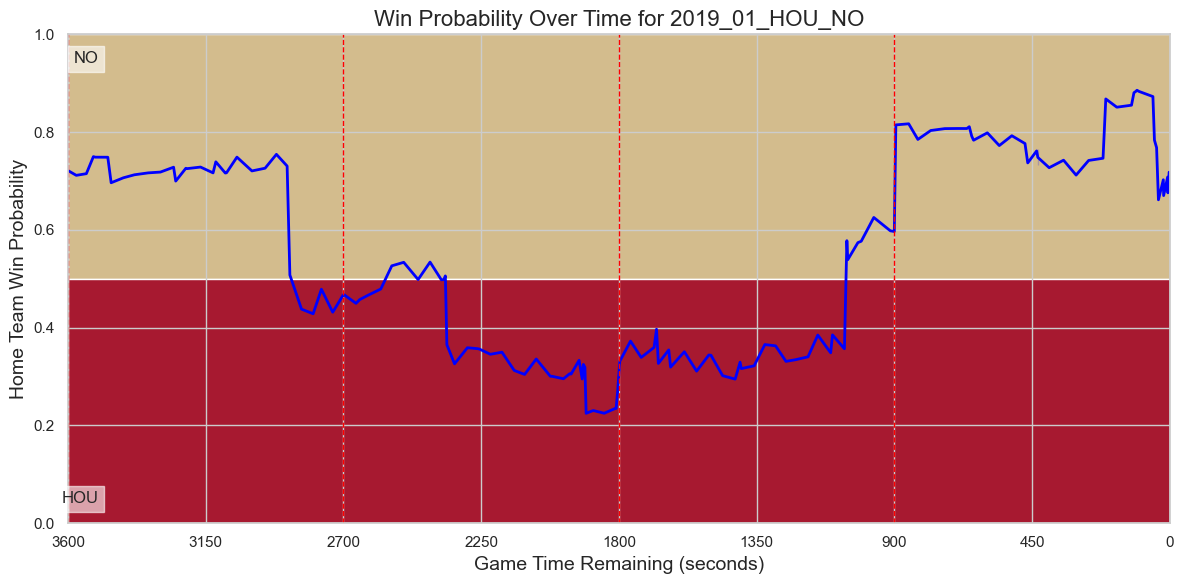

In [495]:
gameid = "2019_01_HOU_NO"
homeid = nfl[nfl['game_id'] == gameid]['home_team'].drop_duplicates().values[0]
awayid = nfl[nfl['game_id'] == gameid]['away_team'].drop_duplicates().values[0]

vertical_lines = [900, 1800, 2700, 3600]

game_data = nfl[nfl['game_id'] == gameid].copy()
game_data.sort_values(by='game_seconds_remaining', inplace=True)

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Rectangle for y between 0.5 and 1 (e.g., representing higher probabilities)
rect1 = patches.Rectangle((0, 0.5), 3600, 0.5, facecolor="#D3BC8D", alpha=1, zorder=0)
ax.add_patch(rect1)

# Rectangle for y between 0 and 0.5 (e.g., representing lower probabilities)
rect2 = patches.Rectangle((0, 0), 3600, 0.5, facecolor="#A71930", alpha=1, zorder=0)
ax.add_patch(rect2)

# Plot the probability line
sns.lineplot(data=game_data, x='game_seconds_remaining', y='prob_home_log',
             linewidth=2, zorder=1, color='blue')

# Add vertical lines at specified times
for vline in vertical_lines:
    plt.axvline(x=vline, color='red', linestyle='--', linewidth=1)

# Customize the x-axis
plt.gca().invert_xaxis()  # Reverse the x-axis to show time remaining
plt.xticks(ticks=range(0, 3601, 450))  # Set x-ticks every 450 seconds
plt.xlim(3600, 0)  # Set x-axis limits from 3600 to 0

# Set y-axis limits
plt.ylim(0, 1)

# Labels
plt.xlabel("Game Time Remaining (seconds)", fontsize=14)
plt.ylabel("Home Team Win Probability", fontsize=14)

# Add annotations for home and away teams
plt.text(3500, 0.95, homeid, horizontalalignment='right', verticalalignment='center',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
plt.text(3500, 0.05, awayid, horizontalalignment='right', verticalalignment='center',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Apply a theme similar to ggplot's theme_bw
sns.set_style("whitegrid")

# Optional: Add a title
plt.title(f"Win Probability Over Time for {gameid}", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

**Insights**
- The home team probability starts at almost 70% in this model. This shows that there is a huge home team advantage during the match; it is not a traditional 50-50 split for the home and away teams.
- Throughout the match, the New Orleans Saints' win probability fell below 50% in the second and third quarters but rose again in the last quarter. This demonstrates the home team's comeback during the game.